In [10]:
#import libraries
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

 **INTRODUCTION**
 
 - Will perform a binary classification on the Census Income datase
 - The goal is to determine if an individual earns more than $50K
 - Will use the Census Income dataset available from the <a href='http://archive.ics.uci.edu/ml/datasets/Adult'>UC Irvine Machine Learning Repository</a>.
 
 To run the notebook on local system, the dataset is trimmed down to 30,000 records and are randomly sorted.

# Data 

In [2]:
data = pd.read_csv('income.csv')
print(data.shape)

(30000, 10)


In [3]:
data.head()

,age,sex,education,education-num,marital-status,workclass,occupation,hours-per-week,income,label
0,27,Male,HS-grad,9,Never-married,Private,Craft-repair,40,<=50K,0
1,47,Male,Masters,14,Married,Local-gov,Exec-managerial,50,>50K,1
2,59,Male,HS-grad,9,Divorced,Self-emp,Prof-specialty,20,<=50K,0
3,38,Female,Prof-school,15,Never-married,Federal-gov,Prof-specialty,57,>50K,1
4,64,Female,11th,7,Widowed,Private,Farming-fishing,40,<=50K,0


In [4]:
#we have imbalanced dataset
data['label'].value_counts()

0    21700
1     8300
Name: label, dtype: int64

In [6]:
#will drop income column as it is just an indicator
data.drop('income', axis=1, inplace= True)

#check na values -- no na values
data.isna().sum().sort_values(ascending = False) / data.shape[0]

age               0.0
sex               0.0
education         0.0
education-num     0.0
marital-status    0.0
workclass         0.0
occupation        0.0
hours-per-week    0.0
label             0.0
dtype: float64

# Feature Engineering 

In [9]:
#check column type
for col in data.columns :
    print(f"{col}  {data[col].dtype} ")

age  int64 
sex  object 
education  object 
education-num  int64 
marital-status  object 
workclass  object 
occupation  object 
hours-per-week  int64 
label  int64 


<AxesSubplot:xlabel='label', ylabel='education-num'>

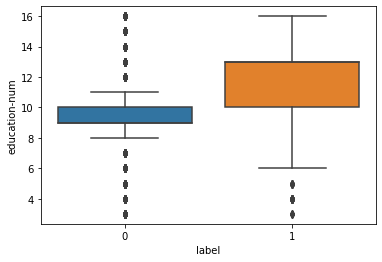

In [11]:
#records with higher education num has higher incomes
sns.boxplot(data= data, x = 'label', y = 'education-num')

## Categorical Columns 

In [12]:
#separate columns into numerical & categorical
cat_cols = ['sex', 'education', 'marital-status', 'workclass', 'occupation']
cont_cols = ['age', 'hours-per-week']
y_col = ['label']

print(f'cat_cols  has {len(cat_cols)} columns') 
print(f'cont_cols has {len(cont_cols)} columns')
print(f'y_col     has {len(y_col)} column')     

cat_cols  has 5 columns
cont_cols has 2 columns
y_col     has 1 column


In [13]:
#converting categorical columns to category dtypes
for cat in cat_cols:
    data[cat] = data[cat].astype('category')

In [14]:
#create embedding for categorical columns
cat_szs = [len(data[col].cat.categories) for col in cat_cols]
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs] #should be minimum of 50 or (size+1/)/2
emb_szs

[(2, 1), (14, 7), (6, 3), (5, 3), (12, 6)]

In [15]:
#create array for categorical columns
sx = data['sex'].cat.codes.values
ed = data['education'].cat.codes.values
ms = data['marital-status'].cat.codes.values
wc = data['workclass'].cat.codes.values
oc = data['occupation'].cat.codes.values

cats = np.stack([sx,ed,ms,wc,oc], 1)

cats[:5]

array([[ 1, 10,  3,  2,  1],
       [ 1, 11,  1,  1,  2],
       [ 1, 10,  0,  3,  7],
       [ 0, 12,  3,  0,  7],
       [ 0,  1,  5,  2,  3]], dtype=int8)

In [16]:
#convert them to torch tensors
cats = torch.tensor(cats, dtype=torch.int64)

## Numerical Features 

In [19]:
#converting them into arrays
conts = np.stack([data[col].values for col in cont_cols], 1)
conts = torch.tensor(conts, dtype=torch.float)
conts[:5]

tensor([[27., 40.],
        [47., 50.],
        [59., 20.],
        [38., 57.],
        [64., 40.]])

## Create Label 

In [21]:
#convert into torch tensor
y = torch.tensor(data[y_col].values).flatten()
print(y.shape)

torch.Size([30000])


In [22]:
b = 30000 # suggested batch size
t = 5000  # suggested test size

cat_train = cats[:b-t]
cat_test  = cats[b-t:b]
con_train = conts[:b-t]
con_test  = conts[b-t:b]
y_train   = y[:b-t]
y_test    = y[b-t:b]

# Modeling

In [25]:
class IncomePredictionModel(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        # Call the parent __init__
        super().__init__()
        
        # Set up the embedding, dropout, and batch normalization layer attributes
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        # Assign a variable to hold a list of layers
        layerlist = []
        
        # Assign a variable to store the number of embedding and continuous layers
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        
        # Iterate through the passed-in "layers" parameter (ie, [200,100]) to build a list of layers
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
        
        # Convert the list of layers into an attribute
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        # Extract embedding values from the incoming categorical data
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        # Perform an initial dropout on the embeddings
        x = self.emb_drop(x)
        
        # Normalize the incoming continuous data
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        
        # Set up model layers
        x = self.layers(x)
        return x

In [26]:
torch.manual_seed(33)
model = IncomePredictionModel(emb_szs, conts.shape[1], 2, [50], p=0.4)
model

IncomePredictionModel(
  (embeds): ModuleList(
    (0): Embedding(2, 1)
    (1): Embedding(14, 7)
    (2): Embedding(6, 3)
    (3): Embedding(5, 3)
    (4): Embedding(12, 6)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=22, out_features=50, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=50, out_features=2, bias=True)
  )
)

In [27]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [28]:
import time
start_time = time.time()

epochs = 200
losses = []

for i in range(epochs):
    i+=1
    y_pred = model(cat_train, con_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss)
    
    # a neat trick to save screen space:
    if i%25 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:   1  loss: 0.81730050
epoch:  26  loss: 0.59609818
epoch:  51  loss: 0.51560700
epoch:  76  loss: 0.46679878
epoch: 101  loss: 0.42924431
epoch: 126  loss: 0.40252391
epoch: 151  loss: 0.38094610
epoch: 176  loss: 0.36304617
epoch: 200  loss: 0.35131103

Duration: 83 seconds


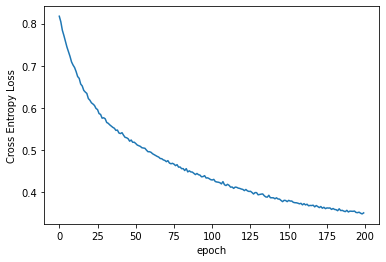

In [29]:
#plot the loss function
plt.plot(range(epochs), [x.detach().numpy() for x in losses])
plt.ylabel('Cross Entropy Loss')
plt.xlabel('epoch');

In [30]:
# performance on test data
with torch.no_grad():
    y_val = model(cat_test, con_test)
    loss = criterion(y_val, y_test)
print(f'Cross Entropy Loss: {loss:.8f}')

Cross Entropy Loss: 0.34282523


In [32]:
#print accuracy
rows = len(y_test)
correct = 0

for i in range(rows):

    if y_val[i].argmax().item() == y_test[i]:
        correct += 1

print(f'\n{correct} out of {rows} = {100*correct/rows:.2f}% correct')


4223 out of 5000 = 84.46% correct


In [33]:
# save the pytorch model
torch.save(model.state_dict(), 'IncomePredictionModel.pt')

In [39]:
conts.shape[1]

2

# Making a Prediction 

In [40]:
#create new model
torch.manual_seed(42)
trained_model = IncomePredictionModel(emb_szs= [(2, 1), (14, 7), (6, 3), (5, 3), (12, 6)],
                                  n_cont= 2,
                                  out_sz= 2, layers= [50], p=0.4)

In [41]:
trained_model.load_state_dict(torch.load('IncomePredictionModel.pt'));
trained_model.eval()

IncomePredictionModel(
  (embeds): ModuleList(
    (0): Embedding(2, 1)
    (1): Embedding(14, 7)
    (2): Embedding(6, 3)
    (3): Embedding(5, 3)
    (4): Embedding(12, 6)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=22, out_features=50, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=50, out_features=2, bias=True)
  )
)

In [42]:
# DON'T WRITE HERE
def test_data(mdl): # pass in the name of the model
    # INPUT NEW DATA
    age = float(input("What is the person's age? (18-90)  "))
    sex = input("What is the person's sex? (Male/Female) ").capitalize()
    edn = int(input("What is the person's education level? (3-16) "))
    mar = input("What is the person's marital status? ").capitalize()
    wrk = input("What is the person's workclass? ").capitalize()
    occ = input("What is the person's occupation? ").capitalize()
    hrs = float(input("How many hours/week are worked? (20-90)  "))

    # PREPROCESS THE DATA
    sex_d = {'Female':0, 'Male':1}
    mar_d = {'Divorced':0, 'Married':1, 'Married-spouse-absent':2, 'Never-married':3, 'Separated':4, 'Widowed':5}
    wrk_d = {'Federal-gov':0, 'Local-gov':1, 'Private':2, 'Self-emp':3, 'State-gov':4}
    occ_d = {'Adm-clerical':0, 'Craft-repair':1, 'Exec-managerial':2, 'Farming-fishing':3, 'Handlers-cleaners':4,
            'Machine-op-inspct':5, 'Other-service':6, 'Prof-specialty':7, 'Protective-serv':8, 'Sales':9, 
            'Tech-support':10, 'Transport-moving':11}

    sex = sex_d[sex]
    mar = mar_d[mar]
    wrk = wrk_d[wrk]
    occ = occ_d[occ]

    # CREATE CAT AND CONT TENSORS
    cats = torch.tensor([sex,edn,mar,wrk,occ], dtype=torch.int64).reshape(1,-1)
    conts = torch.tensor([age,hrs], dtype=torch.float).reshape(1,-1)
    
    # SET MODEL TO EVAL (in case this hasn't been done)
    mdl.eval()

    # PASS NEW DATA THROUGH THE MODEL WITHOUT PERFORMING A BACKPROP
    with torch.no_grad():
        z = mdl(cats, conts).argmax().item()

    print(f'\nThe predicted label is {z}')
    
test_data(model)

What is the person's age? (18-90)  45
What is the person's sex? (Male/Female) Male
What is the person's education level? (3-16) 5
What is the person's marital status? Married
What is the person's workclass? Private
What is the person's occupation? Transport-moving
How many hours/week are worked? (20-90)  56

The predicted label is 1
